# Gaussian Mixture Model
## Angus Mackenzie - 1106817
In this project we are tasked with creating a Gaussian Mixture Model (GMM) that can detect coins. It should be able to produce a mask that shows coin pixels in white and desk pixels in black. 

We need to run our code with 1-10 components and report the accuracy of our system. 

GMM's work by proposing multiple Gaussian's, tweaking their parameters and then updating them. Eventually meeting a specific criteria at which they stop. We can create a generative model, and give it a posterior and generate the probability of the point. The number of components gives us the number of distributions to tweak.

- [ ] Create a GMM Class
    - [ ] Feed in Picture and number of Components
    - [ ] E Step
    - [ ] M Step
    - [ ] EM Algorithm
    - [ ] Likelihood
    
- [ ] Get Prob
- [ ] Desk vs Coin Prob in Bayes
- [ ] Create Mask with Prob

In [1]:
import numpy as np
from scipy import stats
import cv2
import matplotlib.pyplot as plt
from mpmath import *
from tqdm import tqdm

In [2]:
def read_image(name, display=True):
    """
    Given an image, reads it in with CV and plots it with the title
    returns the image
    """
    img = cv2.imread(name,-1)
    if display:
        t = "BGR "+name
        plt.title(t)
        plt.imshow(img)
        plt.show()
    return img

def show_components(bgr,title):
    """
    Given a BGR image, converts it to HSV and displays
    each aspect of BGR and HSV
    """
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    b = bgr[:,:,0]
    g = bgr[:,:,1]
    r = bgr[:,:,2]
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    components = [b,g,r,h,s,v]
    comps = ['Blue','Green','Red','Hue','Saturation','Value']
    fig=plt.figure(figsize=(8, 8))
    t = "Different Components of "+str(title)
    fig.suptitle(t)
    columns = 3
    rows = 2
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(components[i-1])
        # one liner to remove *all axes in all subplots*
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
        plt.title(comps[i-1])
    plt.show()
    
def plot_image(img,title, gray=True):
    """
    Given an image an a title, plots it
    """
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.show()

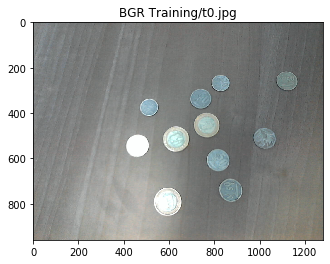

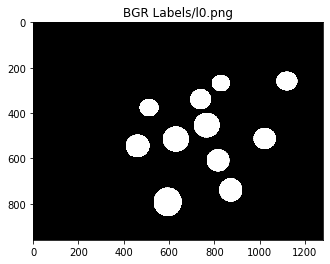

Shape of the image : (960, 1280, 3)
Image Hight 960
Image Width 1280
Dimension of Image 3


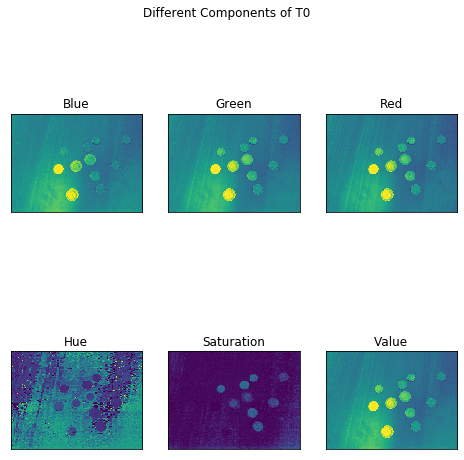

In [3]:
# Identifying Images
train_0 = read_image("Training/t0.jpg")
mask_0  = read_image("Labels/l0.png")

print('Shape of the image : {}'.format(train_0.shape))
print('Image Hight {}'.format(train_0.shape[0]))
print('Image Width {}'.format(train_0.shape[1]))
print('Dimension of Image {}'.format(train_0.ndim))
show_components(train_0, "T0")


The `value` field of `HSV` seems to give a reasonable differentiation between the desk and the coin pixels.

$\lambda$

In [4]:
train_bgr = read_image("Training/t0.jpg",display=False)
train_hsv = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2HSV)
train_mask = cv2.cvtColor(cv2.imread('Labels/l0.png'), cv2.COLOR_BGR2GRAY)
# Make mask more defined
train_mask = np.where(train_mask > 245, 255, 0)
print('Coin pixels: {}'.format(np.sum(train_mask==255)))
print('Non-coin pixels: {}'.format(np.sum(train_mask==0)))

Coin pixels: 86852
Non-coin pixels: 1141948


In [5]:
train_value_coin = train_hsv[:,:,2][np.where(train_mask==255)].ravel()
train_value_desk = train_hsv[:,:,2][np.where(train_mask==0)].ravel()

In [298]:
class GMM:
    """
    Guassian Mixture Model
    """
    def __init__(self, data, num_components, seed = 1337):
        np.random.seed(seed)
        self.data = data
        self.d_size = data.shape[0]
        self.K = num_components
#         self.𝜇 = np.zeros((self.K))
#         self.𝜆 = np.zeros((self.K))
#         self.𝜎 = np.zeros((self.K, self.K, self.K))
        self.old_params = []
        self.log_l = 0
        self.old_logs = []
        
        
    def set_random_params(self):
        self.𝜆 = np.ones(self.K)/self.K
        
        self.𝜇 = np.random.choice(self.data, 2)
        self.𝜎 = []
        for k in range(self.K):
            self.𝜎.append(np.eye(self.K)*np.random.rand())
        self.𝜎 = np.array(self.𝜎)
        print("Parameters set as:")
        print("𝜆:",self.𝜆)
        print("𝜇:",self.𝜇)
        print("𝜎:",self.𝜎)
        
        
    def set_params(self, 𝜇, 𝜎, 𝜆):
        for k in range(self.K):
            self.𝜇[k] = 𝜇[k]
            self.𝜎[k] = 𝜎[k]
            self.𝜆[k] = 𝜆[k]

            
    def train(self, num_iterations=500, Θ=1e-4):
        iter_count = 0
        for i in range(num_iterations):
            for j in range(self.d_size):
                r = self.e_step(self.data[j])
                self.m_step(self.data, r)
            self.log_likelihood()
            iter_count += 1
            print('Iteration %d: log-likelihood is %.6f'%(iter_count, self.log_l))
            if self.log_l - self.old_logs[-1] > Θ:
                break
        print('Terminate at iteration %d:log-likelihood is %.6f'%(iter_count, self.log_l))
            

            
    def log_likelihood(self):
        self.old_logs.append(self.log_l)
        p = np.ndarray((self.d_size, self.K))
        for k in range(self.K):
            p[:, k] = self.𝜆[k] *stats.multivariate_normal.pdf(x=self.data, mean=self.𝜇[k], cov=self.𝜎[k])
        self.log_l = np.sum(np.log(np.sum(p,axis=1)),axis=0)
        
                
#     def e_step(self, X):
#         r_vals = np.zeros((self.K,X.shape[0]))   
#         for k in range(self.K):
#             print(self.𝜎[k])
#             val = self.𝜆[k]*stats.multivariate_normal.pdf(X, mean=self.𝜇[k], cov=self.𝜎[k])
#             sum_components = 0
#             for i in range(self.K):
#                 sum_components+=self.𝜆[i]*stats.multivariate_normal.pdf(X, mean=self.𝜇[i],cov=self.𝜎[i])
#             r_vals[k] = np.round(val/sum_components,3)
#         return r_vals

    def e_step(self, x):
        r = []
        sum_r = 0
        for i in range(self.K):
            rik = self.𝜆[i] * stats.multivariate_normal.pdf(x, mean = self.𝜇[i], cov = self.𝜎[i])
            r.append(rik)
            sum += rik
        return np.array(r) / sum_r

    
    def m_step(self, X, r):
        self.old_params.append((self.𝜆, self.𝜇, self.𝜎))
        for i in range(self.K):
            ri_sum = np.sum(r[i])
            r_sum = np.sum(r)
            self.𝜆[i] =ri_sum/r_sum
            self.𝜇[i] = np.sum(r[i]*X)/ri_sum
            diff = (X-self.𝜇[i]).T
            weighted_sum = np.dot(r[i] * diff, diff.T)
            self.𝜎[i] = weighted_sum/ri_sum
        return self.𝜆, self.𝜇, self.𝜎
    
    
    def predict_point(self, Y):
        """
        Given an unseen point, Y, predict which component it belongs to
        """
        preds = np.zeros(self.K)
        for k in range(self.K):
            preds[k] = stats.multivariate_normal.pdf(x=Y, mean=self.𝜇[k], cov=self.𝜎[k])/np.sum([stats.multivariate_normal.pdf(Y, mean=m,cov=c) for m,c in zip(self.𝜇,self.𝜎)])
        return np.round(preds,3)
    
    
    def predict_all(self, Y):
        """
        Given an array of data of a certain dimensionality, predict which components the data belongs to
        """
        shape = Y.shape
        preds = np.zeros((shape[0],self.K))
        for i in range(shape[0]):
            preds[i] = self.predict_point(Y[i])
        return np.round(preds,3)
    
    
    def info(self):
        print("Components:",self.K)
        print("𝜇",self.𝜇)
        print("𝜎",self.𝜎)
        print("𝜆",self.𝜆)
        print("Data:\n",self.data)

In [299]:
coin_gmm = GMM(train_value_coin, 2)
coin_gmm.set_random_params()
coin_gmm.info()

coin_gmm.train()
coin_gmm.info()

Parameters set as:
𝜆: [0.5 0.5]
𝜇: [134 255]
𝜎: [[[0.15868397 0.        ]
  [0.         0.15868397]]

 [[0.27812652 0.        ]
  [0.         0.27812652]]]
Components: 2
𝜇 [134 255]
𝜎 [[[0.15868397 0.        ]
  [0.         0.15868397]]

 [[0.27812652 0.        ]
  [0.         0.27812652]]]
𝜆 [0.5 0.5]
Data:
 [124 118 114 ... 165 166 166]


ValueError: cannot reshape array of size 4 into shape (1,1)

In [291]:
lll = 0.5
mmm = np.ones(2)*134
ccc = np.array([[0.15868397,0.],[0., 0.15868397]])
x = stats.multivariate_normal(mean=mmm, cov=ccc).pdf(train_value_coin)

ValueError: operands could not be broadcast together with shapes (1,86852) (2,) 

In [ ]:
X_f = np.random.multivariate_normal([0, 3], [[0.5, 0], [0, 0.8]], 20)
X_f = np.vstack((X_f, np.random.multivariate_normal([20, 10], np.identity(2), 50)))
X_f.shape
mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
for i in range(X_f.shape[0]):
    den = 0
    for j in range(2):
        num = sp.stats.multivariate_normal.pdf(X_f[i, :], 
                                               self.mean_arr[j].A1, 
                                               self.sigma_arr[j]) *\
              self.phi[j]
        den += num
        self.w[i, j] = num
    self.w[i, :] /= den
    assert self.w[i, :].sum() - 1 < 1e-4

In [196]:
coin_gmm.predict_point(124)

array([0.594, 0.406])

In [168]:
train_value_coin
np.cov(train_value_coin, rowvar=False)

array(1924.15898268)

In [136]:
# Test data for E-Step taken from 2018 November Exam
𝜆 = np.array([0.5,0.5])
𝜎 = np.array([10,10])
𝜇 = np.array([250,20])
x_test = np.array([255,255,1,3,3])
gmm = GMM(x_test, 2)
gmm.set_params(𝜇, 𝜎, 𝜆) 
gmm.e_step(x_test)

array([[1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1.]])

Expected output:


|n|x|R0|R1|
|---|---|---|---|
|0|255|1|0|
|1|255|1|0|
|2|1|0|1|
|3|3|0|1|
|4|3|0|1|

In [137]:
print(gmm.predict_point(255))
gmm.predict_all(x_test)

[1. 0.]
(5, 2)


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [138]:
# Test data for M-step taken from Test 2 2017
x_ri = np.array([0,0.1,1.1,1.2,0.3])
ri_0 = np.array([0.606, 0.593, 0.402, 0.378, 0.563])
ri_1 = np.array([0.394, 0.407, 0.598, 0.622, 0.437])
ris = np.array([ri_0,ri_1])

Correct output:
mu= [0.44217152, 0.64117168]

cov = [[0.23223415]], [[0.26532686]]

lam = [0.5084, 0.4916]

In [139]:
𝜆 = np.array([0.5,0.5])
𝜎 = np.array([0.4,0.3])
𝜇 = np.array([0.50,0.75])
gmm = GMM(x_ri, 2)
gmm.set_params(𝜇, 𝜎, 𝜆) 
gmm.info()
print(gmm.predict_all(x_ri))

Components: 2
𝜇 [0.5  0.75]
𝜎 [0.4 0.3]
𝜆 [[0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]]
Data:
 [0.  0.1 1.1 1.2 0.3]
(5, 2)
[[0.618 0.382]
 [0.589 0.411]
 [0.404 0.596]
 [0.397 0.603]
 [0.536 0.464]]


In [140]:
gmm.m_step(x_ri,ris)

(array([[0.5084, 0.5084, 0.5084, 0.5084, 0.5084],
        [0.4916, 0.4916, 0.4916, 0.4916, 0.4916]]),
 array([0.44217152, 0.64117168]),
 array([0.23223415, 0.26532686]))

Given the test data above, and the fact that each method seems to achieve the desired output. We must now make a method that works out the likelihood of a particular pixel given the data and the training

In [245]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
        #print(self.sigma_arr)

In [251]:
x_test = np.array([255,255,1,3,3])

In [252]:
gmm = GMM(x_test)
gmm.fit()

ValueError: not enough values to unpack (expected 2, got 1)

In [248]:
gmm.mean_arr

matrix([[20.20148519, 10.09192522],
        [ 0.23100328,  3.03899581]])

In [249]:
gmm.sigma_arr

array([[[ 0.92157852, -0.03695875],
        [-0.03695875,  1.11322582]],

       [[ 0.42561644,  0.04833259],
        [ 0.04833259,  0.39626129]]])

In [250]:
gmm.phi

array([0.71428571, 0.28571429])

In [14]:
data = train_hsv[:,:,2]
k = 2
N, D = = data.shape[0], data.shape[1]
𝜇 = np.vstack((data[0],data[N//2]))
𝜎 = np.ndarray((k, D, D),np.float32)

cov = np.cov(data, rowvar=False)
for i in range(k):
    𝜎[i,:,:] = cov
distributions = []
for i in range(k):
    distributions.append(multivariate_normal(𝜇[i], 𝜎[i]))
np.random.seed(1337)
𝜋 = np.random.rand(k)
likelihood = 0
iterations = 500
Nk = np.array()
for _ in range(iterations):
    # Update Gamma
    p = np.ndarray((N, k))
    for i in range(k):
        p[:, i] = 𝜋[k] * distributions[i].pdf(data)
    norm = np.sum(p, axis=1)
    norm = norm.reshape(norm.shape[0],1)
    𝛾 = p/norm
    Nk = np.sum(𝛾,axis=0)
    Nk = Nk.reshape(Nk.shape[0],-1)
    
    # M Step
    𝜇 = np.divide(np.matmal(np.transpose(𝛾)))

SyntaxError: invalid syntax (<ipython-input-14-08385d5158b6>, line 3)

In [ ]:
def read_data(filename, is_RGB, visualize=False, save=False, save_name=None):
    # read the text data file
    #   data, image = read_data(filename, is_RGB) read the data file named
    #   filename. Return the data matrix with same shape as data in the file.
    #   If is_RGB is False, the data will be regarded as Lab and convert to
    #   RGB format to visualise and save.
    #
    #   data, image = read_data(filename, is_RGB, visualize)
    #   If visualize is True, the data will be shown. Default value is False.
    #
    #   data, image = read_data(filename, is_RGB, visualize, save)
    #   If save is True, the image will be saved in an jpg image with same name
    #   as the text filename. Default value is False.
    #
    #   data, image = read_data(filename, is_RGB, visualize, save, save_name)
    #   The image filename.
    #
    #   Example: data, image = read_data("1_noise.txt", True)
    #   Example: data, image = read_data("cow.txt", False, True, True, "segmented_cow.jpg")

    with open(filename, "r") as f:
        lines = f.readlines()

    data = []

    for line in lines:
        data.append(list(map(float, line.split(" "))))

    data = np.asarray(data).astype(np.float32)

    N, D = data.shape

    cols = int(data[-1, 0] + 1)
    rows = int(data[-1, 1] + 1)
    channels = D - 2
    img_data = data[:, 2:]

    # In numpy, transforming 1d array to 2d is in row-major order, which is different from the way image data is organized.
    image = np.reshape(img_data, [cols, rows, channels]).transpose((1, 0, 2))

    if visualize:
        if channels == 1:
            # for visualizing grayscale image
            cv2.imshow("", image)
        else:
            # for visualizing RGB image
            cv2.imshow("", cv2.cvtColor(image, cv2.COLOR_Lab2BGR))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    if save:
        if save_name is None:
            save_name = filename[:-4] + ".jpg"
        assert save_name.endswith(".jpg") or save_name.endswith(".png"), "Please specify the file type in suffix in 'save_name'!"

        if channels == 1:
            # for saving grayscale image
            cv2.imwrite(save_name, image)
        else:
            # for saving RGB image
            cv2.imwrite(save_name, (cv2.cvtColor(image, cv2.COLOR_Lab2BGR) * 255).astype(np.uint8))

    if not is_RGB:
        image = cv2.cvtColor(image, cv2.COLOR_Lab2RGB)

    return data, image


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class GMM:
    """
    This class define a Gaussian Mixture Model object.

    Args:
        data (array): input data, N x D array, N is the no. of observations, D is the no. of features
        ncomp (int): no. of Gaussian components

    Attributes:
        mu (array): means, dimension: ncomp x D
        sigma (array): covariance matrix, dimension: ncomp x D x D
        pi (array): mixing coefficients, dimension: ncomp
        gamma (array): responsibilities, dimension: N x ncomp
        likelihood (float): log likelihood

    """

    def __init__(self, data, ncomp):

        self.__data = data
        self.__K = ncomp
        self.__N, self.__D = data.shape[0], data.shape[1]

        # Initialize mu, sigma, normal distributions and  pi
        self.mu = np.vstack((self.__data[0], self.__data[self.__N // 2]))
        self.sigma = np.ndarray((self.__K, self.__D, self.__D), np.float32)

        cov = np.cov(data, rowvar=False)
        for i in range(self.__K):
            self.sigma[i, :, :] = cov
        self.__update_distributions()
        np.random.seed(100)
        self.pi = np.random.rand(self.__K)

        self.likelihood = 0

    def fit(self, max_steps=500):
        """
        Fit the multivariate normal distributions
        :param max_steps: maximum number of iterations
        """
        for _ in range(max_steps):
            # E step
            self.__update_gamma()

            # M step
            self.__update_mu()
            self.__update_sigma()
            self.__update_pi()

            # Evaluate log likelihood
            self.__update_distributions()
            self.__compute_likelihood()
            print(self.likelihood)

            # check convergence
            if abs(self.likelihood - self.__likelihood_old) <= 1e-7:
                return

    def __update_gamma(self):
        """
        Update responsibilities
        """

        probs = np.ndarray((self.__N, self.__K))

        for k in range(self.__K):
            probs[:, k] = self.pi[k] * self.distributions[k].pdf(self.__data)

        l1_norm = np.sum(probs, axis=1)
        l1_norm = l1_norm.reshape(l1_norm.shape[0], 1)
        self.gamma = probs / l1_norm

        N_k = np.sum(self.gamma, axis=0)
        self.__N_k = N_k.reshape(N_k.shape[0], -1)

    def __update_mu(self):
        """
        Update means
        """
        self.mu = np.divide(np.matmul(np.transpose(self.gamma), self.__data), self.__N_k)

    def __update_sigma(self):
        """
        Update covariance matrices
        """
        for i in range(self.__K):
            gamma = self.gamma[:, i]
            gamma = gamma.reshape(gamma.shape[0], -1)
            mean = self.mu[i, :]
            mean = mean.reshape(-1, mean.shape[0])
            data_shifted = np.subtract(self.__data, mean)
            cov = np.divide(np.matmul(np.transpose(np.multiply(gamma, data_shifted)), data_shifted), self.__N_k[i])
            self.sigma[i, :, :] = cov

    def __update_pi(self):
        """
        Update mixing coefficients
        """
        self.pi = np.divide(self.__N_k, self.__N)

    def __update_distributions(self):
        """
        Update the normal distributions based on the new parameters
        """
        self.distributions = []
        for i in range(self.__K):
            self.distributions.append(multivariate_normal(self.mu[i], self.sigma[i]))

    def __compute_likelihood(self):
        """
        Compute the log likelihood
        """
        # save the old likelihood
        self.__likelihood_old = self.likelihood

        probs = np.ndarray((self.__N, self.__K))
        for k in range(self.__K):
            probs[:, k] = self.pi[k] * self.distributions[k].pdf(self.__data)
        self.likelihood = np.sum(np.log(np.sum(probs, axis=1)), axis=0)

In [ ]:
print(gmm.likelihood)

In [ ]:
max_steps = 100

# Load data
data, image = read_data("zebra.txt", False)
x, y = image.shape[0], image.shape[1]
N = x * y
image = image.reshape(N, image.shape[2])
# Fit GMM model
gmm = GMM(data, 2)
gmm.fit(max_steps)

# Generate mask
og_mask = np.argmax(gmm.gamma, axis=1)
mask = og_mask.reshape(og_mask.shape[0], 1)


In [ ]:
mask = og_mask.reshape((y,x))
rot_mask = np.rot90(np.rot90(np.rot90(mask)))
rot_mask = np.fliplr(rot_mask)
mask = rot_mask.reshape(y*x, 1)
print(mask.shape)
foreground = np.multiply(mask, image)
print(foreground.shape)
background = image - foreground
print(background.shape)
# mask = mask.reshape((x, y))
# background = background.reshape((x, y))
# foreground = foreground.reshape((x, y))

# # Save images
# plt.imshow(mask, cmap=cm.gray)
# plt.show()
# plt.imshow(background, cmap=cm.gray)
# plt.show()
# plt.imshow(foreground, cmap=cm.gray)
# plt.show()

In [ ]:
mask = og_mask.reshape((y,x))
print(mask.shape)
rot_mask = np.rot90(np.rot90(np.rot90(mask)))
mir_mask = np.fliplr(rot_mask)
print(rot_mask.shape)
plt.imshow(mir_mask)
plt.show()
bg = background.reshape((x, y,3))
fg = foreground.reshape((x, y,3))
# plt.imshow(mask, cmap=cm.gray)
# plt.show()
plt.imshow(bg, cmap=cm.gray)
plt.show()
plt.imshow(fg, cmap=cm.gray)
plt.show()

In [ ]:
nmask = mask.reshape(mask.shape[0], 1)
rmask = np.rot90(np.rot90(np.rot90(nmask.reshape((y,x)))))
plt.imshow(rmask)

In [ ]:
# rotated_mask = mask.reshape(mask.shape[1],mask.shape[0])
# rotated_mask = np.fliplr(rotated_mask)
# rotated_mask = np.rot90(rotated_mask)
# rotated_mask = rotated_mask.flatten()
# mask = rotated_mask

# Separate background and foreground
foreground = np.multiply(mask, image)
background = image[:,0] - foreground
mask = mask.reshape((x, y))
background = background.reshape((x, y))
foreground = foreground.reshape((x, y))

# Save images
plt.imshow(mask, cmap=cm.gray)
plt.show()
plt.imshow(background, cmap=cm.gray)
plt.show()
plt.imshow(foreground, cmap=cm.gray)
plt.show()

In [ ]:
from PIL import Image
rotated_mask = mask.reshape(mask.shape[1],mask.shape[0])
rotated_mask = np.fliplr(rotated_mask)
rotated_mask = np.rot90(rotated_mask)
rotated_mask = rotated_mask.flatten()
image = image.reshape(N, image.shape[2])
foreground = np.multiply(rotated_mask, image)
background = image - foreground
background = background.reshape((x, y, 3))
foreground = foreground.reshape((x, y, 3))
plt.imshow(rotated_mask,cmap="gray")
plt.imshow(rotated_mask, cmap=cm.gray)
plt.show()
plt.imshow(background, cmap=cm.gray)
plt.show()
plt.imshow(foreground, cmap=cm.gray)
plt.show()

In [ ]:
train_hsv[:,:,2].shape

$$
\begin{array}{l}{=\frac{\lambda_{k} \mathrm{Norm}_{\mathrm{x}_{i}}\left[\mu_{k}, \Sigma_{k}\right]}{\sum_{j=1}^{K} \lambda_{j} \operatorname{Norm}_{\mathrm{x}_{i}}\left[\mu_{j}, \Sigma_{j}\right]}} \\ {=r_{i k}}\end{array}
$$

In [ ]:
# Test Data:
k = 2
𝜆 = np.array([0.5,0.5])
𝜎_2 = np.array([10,10])
𝜇 = np.array([250,20])
x_n = 5
x = np.array([255,255,1,3,3])
# k = 2
# 𝜆 = np.array([0.25,0.75])
# 𝜎_2 = np.array([10,10])
# 𝜇 = np.array([10,1])
# x_n = 5
# x = np.array([1,2,3,9,7])
# k = 2
# 𝜆 = np.array([0.5,0.5])
# 𝜎_2 = np.array([0.4,0.3])
# 𝜇 = np.array([0.50,0.75])
# x_n = 5
# x = np.array([0,0.1,1.1,1.2,0.3])

In [ ]:
def e_step(k, 𝜆, 𝜎_2, 𝜇, x):
    for i in range(k):
        val = 𝜆[i]*stats.multivariate_normal.pdf(x, mean=𝜇[i], cov=𝜎_2[i])
        sum_components = 0
        for j in range(k):
            sum_components+=𝜆[j]*stats.multivariate_normal.pdf(x, mean=𝜇[j],cov=𝜎_2[j])
        print(np.round(val/sum_components,3))

In [ ]:
e_step(k, 𝜆, 𝜎_2, 𝜇, x)

$$
\begin{aligned} \lambda_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k}}{\sum_{j=1}^{K} \sum_{i=1}^{I} r_{i j}} \\ \boldsymbol{\mu}_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k} \mathbf{x}_{i}}{\sum_{i=1}^{I} r_{i k}} \\ \boldsymbol{\Sigma}_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k}\left(\mathbf{x}_{i}-\boldsymbol{\mu}_{k}^{[t+1]}\right)\left(\mathbf{x}_{i}-\boldsymbol{\mu}_{k}^{[t+1]}\right)^{T}}{\sum_{i=1}^{I} r_{i k}} \end{aligned}
$$

In [ ]:
x_ri = np.array([0,0.1,1.1,1.2,0.3])
ri_0 = np.array([0.606, 0.593, 0.402, 0.378, 0.563])
ri_1 = np.array([0.394, 0.407, 0.598, 0.622, 0.437])
ris = np.array([ri_0,ri_1])

In [ ]:
def m_step(x, k, riks):
    𝜆 = np.zeros((k))
    𝝁 = np.zeros((k))
    𝜎_2 = np.zeros((k))
    for i in range(k):
        𝜆[i] = np.sum(riks[i])/np.sum(riks)
        𝝁[i] = np.sum(riks[i]*x)/np.sum(riks[i])
        covar_sum = 0
        for j in range(len(x)):
            covar_sum += (riks[i][j] * (x[j]-𝝁[i])*(x[j]-𝝁[i]).T)/np.sum(riks[i])
        𝜎_2[i] = covar_sum
    return 𝜆, 𝝁, 𝜎_2

In [ ]:
m_step(x_ri,2,ris)

In [ ]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [ ]:
iris = datasets.load_iris()
X = iris.data
X[:20]

In [ ]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [ ]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

In [ ]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [ ]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

In [ ]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [ ]:

def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [ ]:

def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [ ]:

n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

In [ ]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)


In [ ]:

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])